<a href="https://colab.research.google.com/github/junaaaak/predicting-customer-churn/blob/main/code/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [12]:
df_train=pd.read_csv('/content/train.csv')
df_test=pd.read_csv('/content/test.csv')

In [13]:
# Numeric columns
numeric_df = df_train.select_dtypes(include=['int64', 'float64'])

# Categorical columns
categorical_df = df_train.select_dtypes(include=['object'])

# Initial Exploration

In [14]:
df_train.head(3)

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0


There is a high correlation between total charges and monthly charges, so we will remove monthly charges.

In [15]:
df_train = df_train.drop(['MonthlyCharges','CustomerID'],axis = 1)
df_test = df_test.drop(['MonthlyCharges','CustomerID'],axis =1 )

In [16]:
df_train.head(3)

,AccountAge,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,Churn
0,20,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,63.531377,10,Sci-Fi,2.176498,4,Male,3,No,No,0
1,57,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,25.725595,18,Action,3.478632,8,Male,23,No,Yes,0
2,73,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,57.364061,23,Fantasy,4.238824,6,Male,1,Yes,Yes,0


In [17]:
# Numeric columns
numeric_df = df_train.select_dtypes(include=['int64', 'float64'])

# Categorical columns
categorical_df = df_train.select_dtypes(include=['object'])

# Encoding Categorical Variables

In [18]:
def encode_dataset(df_train):
    # 1. Ordinal mapping
    subscription_order = {'Basic': 0, 'Standard': 1, 'Premium': 2}
    df_train['SubscriptionType'] = df_train['SubscriptionType'].map(subscription_order)

    # 2. Binary mapping (Yes/No → 1/0)
    binary_cols = ['PaperlessBilling', 'MultiDeviceAccess', 'ParentalControl', 'SubtitlesEnabled']
    for col in binary_cols:
        df_train[col] = df_train[col].map({'No': 0, 'Yes': 1})

    # 3. Nominal one-hot encoding
    nominal_cols = ['PaymentMethod', 'ContentType', 'DeviceRegistered', 'GenrePreference', 'Gender']
    df_train = pd.get_dummies(df_train, columns=nominal_cols, drop_first=True)
    df_train = df_train.astype(int)

    return df_train

In [19]:
df_train_encoded = encode_dataset(df_train)

In [20]:
df_train_encoded.head(3)

,AccountAge,TotalCharges,SubscriptionType,PaperlessBilling,MultiDeviceAccess,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,...,ContentType_Movies,ContentType_TV Shows,DeviceRegistered_Mobile,DeviceRegistered_TV,DeviceRegistered_Tablet,GenrePreference_Comedy,GenrePreference_Drama,GenrePreference_Fantasy,GenrePreference_Sci-Fi,Gender_Male
0,20,221,2,0,0,36,63,10,2,4,...,0,0,1,0,0,0,0,0,1,1
1,57,294,0,1,0,32,25,18,3,8,...,1,0,0,0,1,0,0,0,0,1
2,73,883,0,1,0,7,57,23,4,6,...,1,0,0,0,0,0,0,1,0,1


In [21]:
df_test_encoded = encode_dataset(df_test)

In [22]:
df_test_encoded.head(3)

,AccountAge,TotalCharges,SubscriptionType,PaperlessBilling,MultiDeviceAccess,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,...,ContentType_Movies,ContentType_TV Shows,DeviceRegistered_Mobile,DeviceRegistered_TV,DeviceRegistered_Tablet,GenrePreference_Comedy,GenrePreference_Drama,GenrePreference_Fantasy,GenrePreference_Sci-Fi,Gender_Male
0,38,679,2,0,0,29,122,42,3,2,...,0,1,0,1,0,1,0,0,0,1
1,77,763,0,1,0,36,57,43,2,2,...,0,1,0,1,0,0,0,0,0,0
2,5,75,1,0,1,7,140,14,4,2,...,0,1,0,0,0,0,0,0,1,0


In [23]:
df_test.columns

Index(['AccountAge', 'TotalCharges', 'SubscriptionType', 'PaymentMethod',
       'PaperlessBilling', 'ContentType', 'MultiDeviceAccess',
       'DeviceRegistered', 'ViewingHoursPerWeek', 'AverageViewingDuration',
       'ContentDownloadsPerMonth', 'GenrePreference', 'UserRating',
       'SupportTicketsPerMonth', 'Gender', 'WatchlistSize', 'ParentalControl',
       'SubtitlesEnabled'],
      dtype='object')

# Scaling Numerical Features

In [24]:
from sklearn.preprocessing import StandardScaler

features = ['AccountAge', 'TotalCharges', 'ViewingHoursPerWeek',
            'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating',
            'SupportTicketsPerMonth', 'WatchlistSize']

scaler = StandardScaler()

# Fit and transform the features
df_train_encoded[features] = scaler.fit_transform(df_train_encoded[features])

In [25]:
df_test_encoded.head(3)

,AccountAge,TotalCharges,SubscriptionType,PaperlessBilling,MultiDeviceAccess,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,...,ContentType_Movies,ContentType_TV Shows,DeviceRegistered_Mobile,DeviceRegistered_TV,DeviceRegistered_Tablet,GenrePreference_Comedy,GenrePreference_Drama,GenrePreference_Fantasy,GenrePreference_Sci-Fi,Gender_Male
0,38,679,2,0,0,29,122,42,3,2,...,0,1,0,1,0,1,0,0,0,1
1,77,763,0,1,0,36,57,43,2,2,...,0,1,0,1,0,0,0,0,0,0
2,5,75,1,0,1,7,140,14,4,2,...,0,1,0,0,0,0,0,0,1,0


In [26]:
df_test_encoded[features] =scaler.fit_transform(df_test_encoded[features])

# Model

In [27]:
X = df_train_encoded.drop('Churn', axis=1)
y = df_train_encoded['Churn']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [29]:
class_counts = np.bincount(y_train)
total = len(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Scale pos weight for XGBoost: {scale_pos_weight:.2f}")

Scale pos weight for XGBoost: 4.52


In [30]:
models = {}
results = {}

# 1. XGBoost with scale_pos_weight
models['XGBoost'] = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)

# 2. LightGBM with balanced class weights
models['LightGBM'] = lgb.LGBMClassifier(
    class_weight='balanced',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

# 3. Random Forest with balanced class weights
models['RandomForest'] = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)




print("All models initialized!")

All models initialized!


In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"TRAINING {name.upper()}")
    print('='*50)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

    # Train on full training set
    model.fit(X_train, y_train)
    print(f"Model {name} trained successfully!")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Test AUC: {test_auc:.4f}")

    # Store results
    results[name] = {
        'model': model,
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'test_auc': test_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


TRAINING XGBOOST
CV AUC: 0.7435 (+/- 0.0058)
Model XGBoost trained successfully!
Test AUC: 0.7508

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.77     39921
           1       0.32      0.69      0.44      8837

    accuracy                           0.68     48758
   macro avg       0.61      0.68      0.61     48758
weighted avg       0.80      0.68      0.71     48758


TRAINING LIGHTGBM
CV AUC: 0.7439 (+/- 0.0060)
Model LightGBM trained successfully!
Test AUC: 0.7507

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     39921
           1       0.32      0.70      0.44      8837

    accuracy                           0.68     48758
   macro avg       0.61      0.68      0.61     48758
weighted avg       0.80      0.68      0.71     48758


TRAINING RANDOMFOREST
CV AUC: 0.7355 (+/- 0.0069)
Model RandomForest trained successfully!
Test A

In [32]:
print(f"\n{'='*50}")
print("CREATING ENSEMBLE MODEL")
print('='*50)

# Get top 3 models based on CV AUC
sorted_models = sorted(results.items(), key=lambda x: x[1]['cv_auc_mean'], reverse=True)[:3]
ensemble_models = [(name, results[name]['model']) for name, _ in sorted_models]

print(f"Ensemble will use: {[name for name, _ in ensemble_models]}")

# Create voting ensemble
ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')

# Train ensemble
cv_scores_ensemble = cross_val_score(ensemble, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"Ensemble CV AUC: {cv_scores_ensemble.mean():.4f} (+/- {cv_scores_ensemble.std()*2:.4f})")

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
y_pred_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]
test_auc_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble)

# Store ensemble results
results['Ensemble'] = {
    'model': ensemble,
    'cv_auc_mean': cv_scores_ensemble.mean(),
    'cv_auc_std': cv_scores_ensemble.std(),
    'test_auc': test_auc_ensemble,
    'y_pred': y_pred_ensemble,
    'y_pred_proba': y_pred_proba_ensemble
}

print(f"Ensemble Test AUC: {test_auc_ensemble:.4f}")
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


CREATING ENSEMBLE MODEL
Ensemble will use: ['LightGBM', 'XGBoost', 'RandomForest']
Ensemble CV AUC: 0.7439 (+/- 0.0062)
Ensemble Test AUC: 0.7509

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78     39921
           1       0.32      0.69      0.44      8837

    accuracy                           0.68     48758
   macro avg       0.62      0.69      0.61     48758
weighted avg       0.80      0.68      0.72     48758



In [33]:
print(f"\n{'='*60}")
print("FINAL MODEL COMPARISON")
print('='*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_AUC_Mean': [results[model]['cv_auc_mean'] for model in results.keys()],
    'CV_AUC_Std': [results[model]['cv_auc_std'] for model in results.keys()],
    'Test_AUC': [results[model]['test_auc'] for model in results.keys()]
}).sort_values('Test_AUC', ascending=False)

print(comparison_df.round(4))

best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest performing model: {best_model_name}")
print(f"Best Test AUC: {comparison_df.iloc[0]['Test_AUC']:.4f}")


FINAL MODEL COMPARISON
          Model  CV_AUC_Mean  CV_AUC_Std  Test_AUC
3      Ensemble       0.7439      0.0031    0.7509
0       XGBoost       0.7435      0.0029    0.7508
1      LightGBM       0.7439      0.0030    0.7507
2  RandomForest       0.7355      0.0035    0.7424

Best performing model: Ensemble
Best Test AUC: 0.7509


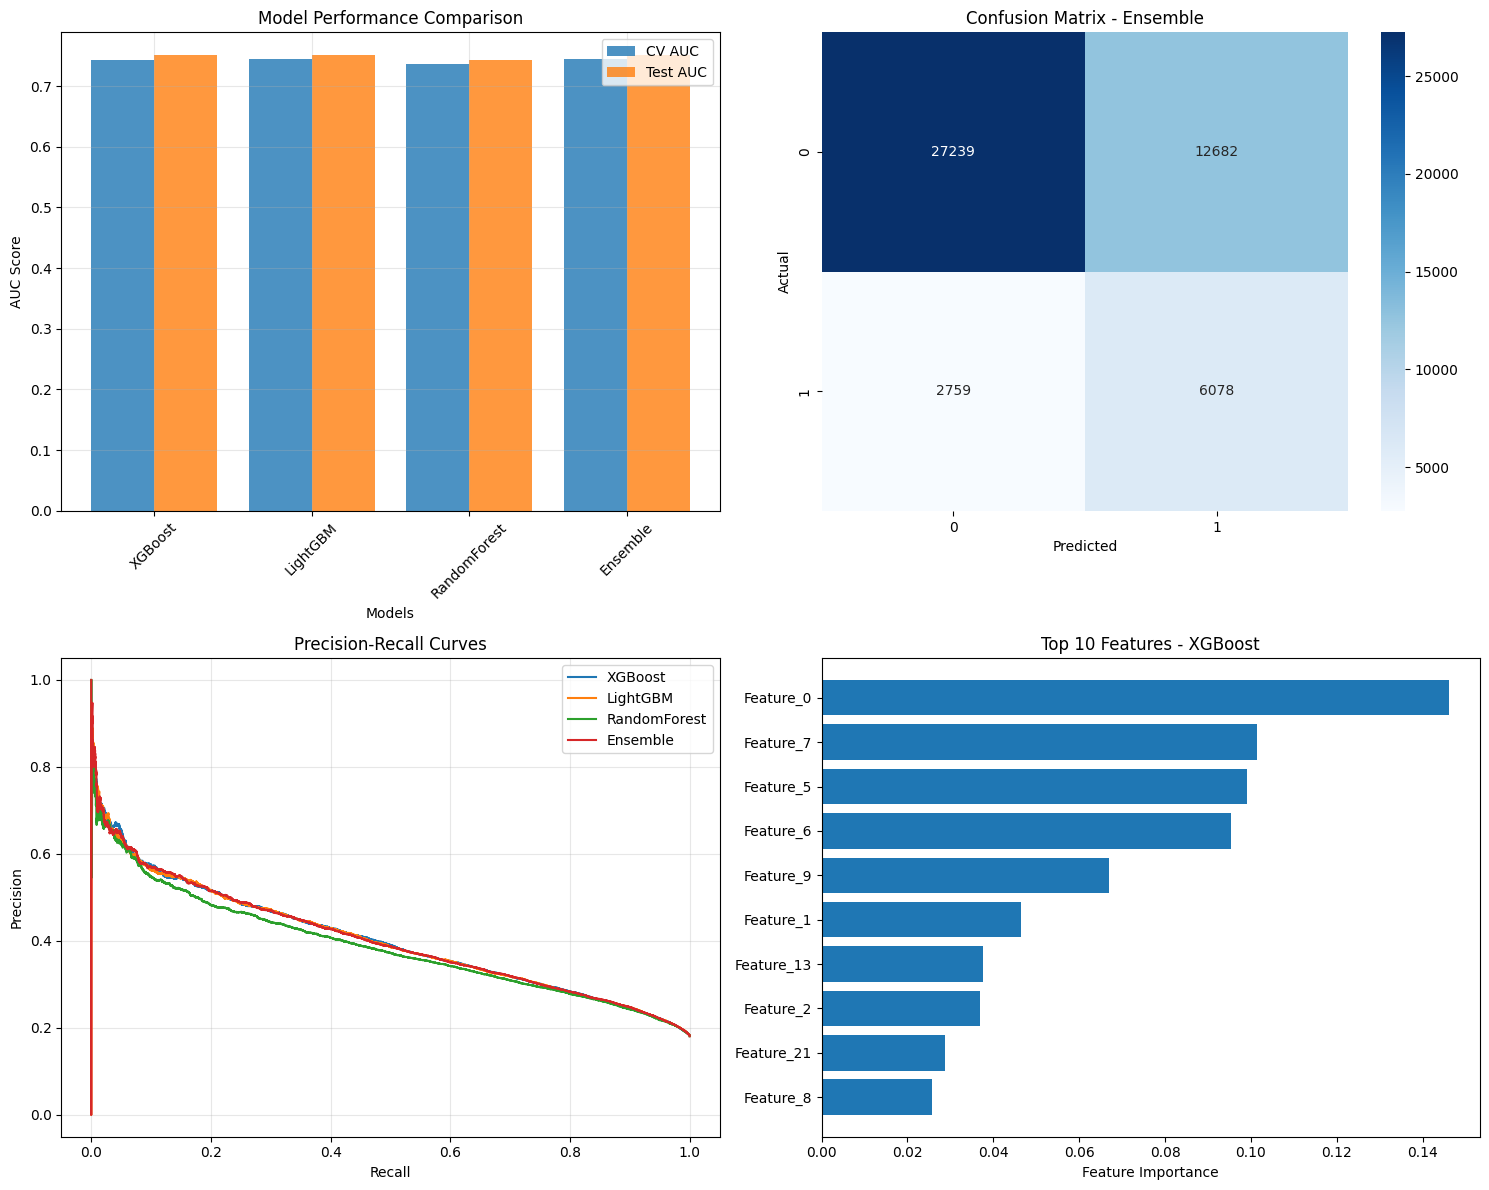

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. AUC Comparison
models_list = list(results.keys())
test_aucs = [results[model]['test_auc'] for model in models_list]
cv_aucs = [results[model]['cv_auc_mean'] for model in models_list]

x = np.arange(len(models_list))
axes[0,0].bar(x - 0.2, cv_aucs, 0.4, label='CV AUC', alpha=0.8)
axes[0,0].bar(x + 0.2, test_aucs, 0.4, label='Test AUC', alpha=0.8)
axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('AUC Score')
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(models_list, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Confusion Matrix for best model
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f'Confusion Matrix - {best_model_name}')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. Precision-Recall Curves
for model_name in results.keys():
    precision, recall, _ = precision_recall_curve(y_test, results[model_name]['y_pred_proba'])
    axes[1,0].plot(recall, precision, label=f'{model_name}')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curves')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Feature importance for best tree-based model
tree_models = ['XGBoost', 'LightGBM', 'RandomForest']
best_tree_model = None
for model in tree_models:
    if model in results and hasattr(results[model]['model'], 'feature_importances_'):
        best_tree_model = model
        break

if best_tree_model:
    importances = results[best_tree_model]['model'].feature_importances_
    feature_names = [f'Feature_{i}' for i in range(len(importances))]

    # Get top 10 features
    top_indices = np.argsort(importances)[-10:]
    axes[1,1].barh(range(10), importances[top_indices])
    axes[1,1].set_yticks(range(10))
    axes[1,1].set_yticklabels([feature_names[i] for i in top_indices])
    axes[1,1].set_xlabel('Feature Importance')
    axes[1,1].set_title(f'Top 10 Features - {best_tree_model}')

plt.tight_layout()
plt.show()

In [35]:
df_test_encoded.head(3)

,AccountAge,TotalCharges,SubscriptionType,PaperlessBilling,MultiDeviceAccess,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,...,ContentType_Movies,ContentType_TV Shows,DeviceRegistered_Mobile,DeviceRegistered_TV,DeviceRegistered_Tablet,GenrePreference_Comedy,GenrePreference_Drama,GenrePreference_Fantasy,GenrePreference_Sci-Fi,Gender_Male
0,-0.643570,-0.131854,2,0,0,0.801489,0.589609,1.214366,0.447537,-0.871734,...,0,1,0,1,0,1,0,0,0,1
1,0.493959,0.029443,0,1,0,1.424223,-0.694167,1.283565,-0.446835,-0.871734,...,0,1,0,1,0,0,0,0,0,0
2,-1.606093,-1.291651,1,0,1,-1.155677,0.945116,-0.723184,1.341910,-0.871734,...,0,1,0,0,0,0,0,0,1,0


# Testing the model against the Test Dataframe

In [36]:
y_pred_ensemble_test = ensemble.predict(df_test_encoded)
y_pred_proba_ensemble_test = ensemble.predict_proba(df_test_encoded)[:, 1]

print("Predictions on new data:")
print(f"Predicted churners: {sum(y_pred_ensemble_test)}")
print(f"Predicted churn rate: {sum(y_pred_ensemble_test)/len(y_pred_ensemble_test)*100:.2f}%")

# Save predictions to see results (Optional)
prediction_results = pd.DataFrame({
    'prediction': y_pred_ensemble_test,
    'churn_probability': y_pred_proba_ensemble_test
})
print(prediction_results.head())

Predictions on new data:
Predicted churners: 39281
Predicted churn rate: 37.60%
   prediction  churn_probability
0           0           0.371169
1           0           0.209844
2           1           0.708467
3           0           0.164098
4           0           0.404588


# Observation
- The model predicted a **38% churn rate**, indicating a relatively high potential for customer loss.
- Implementing **customer retention strategies** is crucial to reduce churn.

# Conclusion
- This dataset serves as an excellent resource for:
  - **Learning churn prediction techniques**
  - **Handling class imbalance effectively**
  - **Exploring ensemble models** to enhance predictive performance
- Model performance was evaluated on a **test dataset** to validate results.